Problem 4: Data Science Salaries | Ensemble & Decision Tree

a) Data preprocessing.

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import warnings

# ignore  warnings
warnings.filterwarnings("ignore")


# Load the dataset
ds_salary = pd.read_csv('ds_salaries.csv')

# Drop irrelevant columns if needed
ds_salary = ds_salary.drop(['salary_currency', 'salary_in_usd'], axis=1)

# Handling Missing Values
ds_salary.fillna(ds_salary.median(), inplace=True)  # Fill missing numerical values with median
ds_salary['experience_level'].fillna(ds_salary['experience_level'].mode()[0], inplace=True)  # Fill missing categorical values with mode



# Feature Scaling
num_cols = ['work_year', 'salary', 'remote_ratio']
scaler = StandardScaler()
ds_salary[num_cols] = scaler.fit_transform(ds_salary[num_cols])





b) Extract useful information using data visualization and considering the “job_title” column.

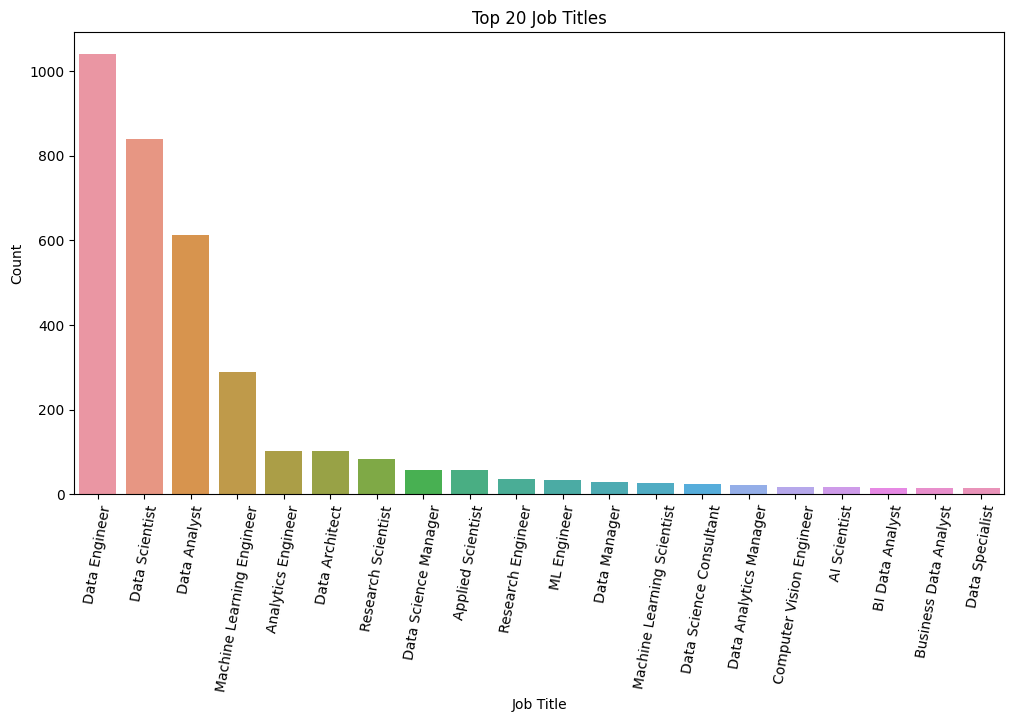

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the top 20 job titles
top_20_jobs = ds_salary['job_title'].value_counts().nlargest(20).index

plt.figure(figsize=(12, 6))
sns.countplot(x='job_title', data=ds_salary, order=top_20_jobs)
plt.xticks(rotation=80)
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.title('Top 20 Job Titles')
plt.show()



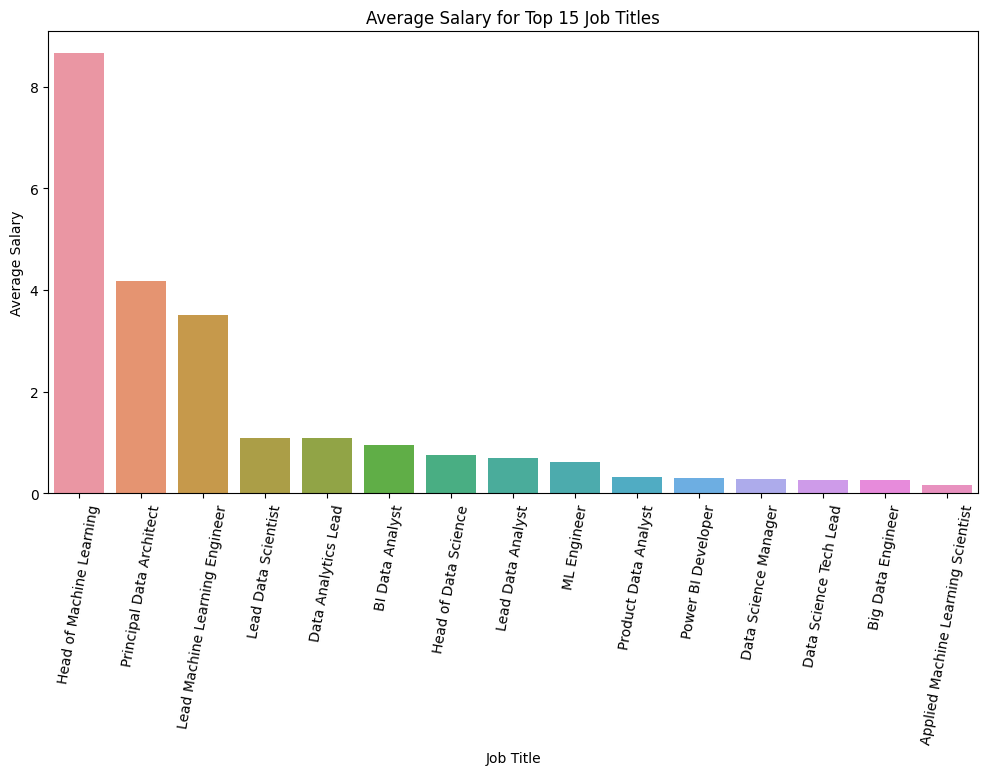

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average salary for each job title
top_15_job_salaries = ds_salary.groupby('job_title')['salary'].mean().nlargest(15)

# Plotting average salary for the top 15 job titles
plt.figure(figsize=(12, 6))
sns.barplot(x=top_15_job_salaries.index, y=top_15_job_salaries.values, ci=None)
plt.xticks(rotation=80)
plt.xlabel('Job Title')
plt.ylabel('Average Salary')
plt.title('Average Salary for Top 15 Job Titles')
plt.show()

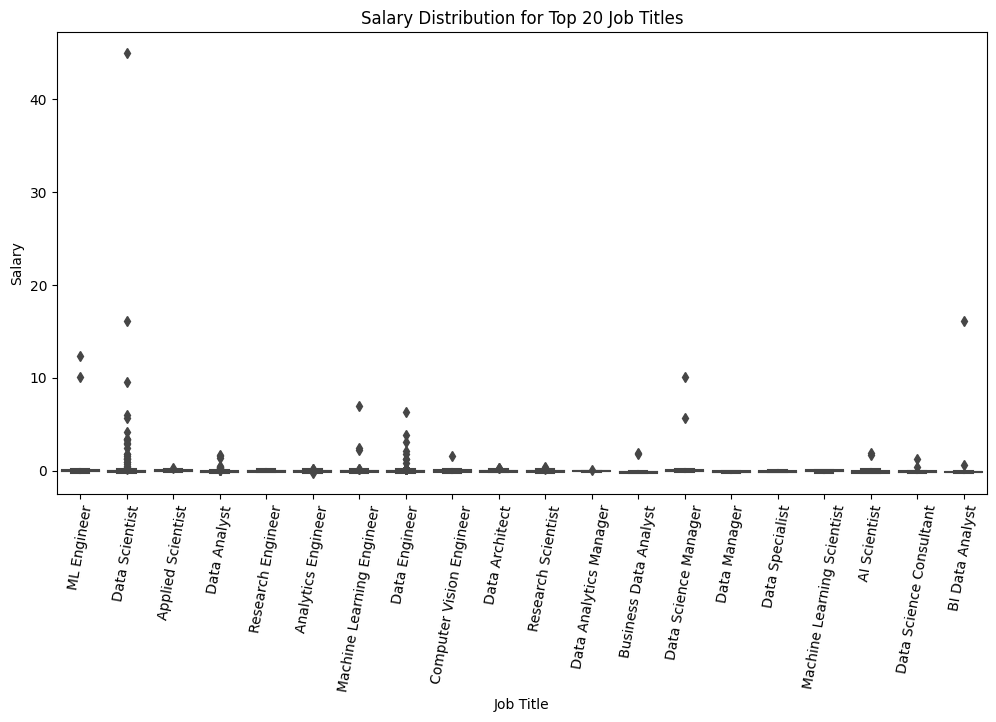

In [61]:
# Filter the dataset for the top 20 job titles
top_20_jobs = ds_salary['job_title'].value_counts().nlargest(20).index
ds_salary_top_20_jobs = ds_salary[ds_salary['job_title'].isin(top_20_jobs)]

# Plotting boxplots of salary for the top 20 job titles
plt.figure(figsize=(12, 6))
sns.boxplot(x='job_title', y='salary', data=ds_salary_top_20_jobs)
plt.xticks(rotation=80)
plt.xlabel('Job Title')
plt.ylabel('Salary')
plt.title('Salary Distribution for Top 20 Job Titles')
plt.show()

do encoding

In [62]:
# Encoding Categorical Variables
cat_cols = ['experience_level' , 'employment_type', 'employee_residence', 'company_location', 'company_size' , 'job_title']
enc = OneHotEncoder(sparse=False, drop='first')
encoded_features = enc.fit_transform(ds_salary[cat_cols])
encoded_cols = pd.DataFrame(encoded_features, columns=[f"{col}_{value}" for col in cat_cols for value in enc.categories_[cat_cols.index(col)][1:]])
ds_salary = pd.concat([ds_salary, encoded_cols], axis=1)
ds_salary.drop(cat_cols, axis=1, inplace=True)



In [63]:
print(ds_salary)

      work_year     salary  remote_ratio  experience_level_EX  \
0      0.905994  -0.164827      1.105918                  0.0   
1      0.905994  -0.239277      1.105918                  0.0   
2      0.905994  -0.245978      1.105918                  0.0   
3      0.905994  -0.023371      1.105918                  0.0   
4      0.905994  -0.105266      1.105918                  0.0   
...         ...        ...           ...                  ...   
3750  -3.433303   0.329525      1.105918                  0.0   
3751  -1.986870  -0.059107      1.105918                  0.0   
3752  -3.433303  -0.127602      1.105918                  0.0   
3753  -3.433303  -0.135047      1.105918                  0.0   
3754  -1.986870  10.139124      0.076743                  0.0   

      experience_level_MI  experience_level_SE  employment_type_FL  \
0                     0.0                  1.0                 0.0   
1                     1.0                  0.0                 0.0   
2        

c) split the dataset into train and test.

In [64]:

X = ds_salary.drop('salary', axis=1)
target = ds_salary['salary']

# Split the dataset into train and test sets
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.2, random_state=42)
print(target_train.head(5))
print(X_train.head(5))

2238   -0.231832
485    -0.057916
2177   -0.135047
3305   -0.050769
1769   -0.023371
Name: salary, dtype: float64
      work_year  remote_ratio  experience_level_EX  experience_level_MI  \
2238  -0.540438     -0.952433                  0.0                  0.0   
485    0.905994      1.105918                  0.0                  1.0   
2177  -0.540438     -0.952433                  0.0                  0.0   
3305  -0.540438      1.105918                  0.0                  0.0   
1769   0.905994      1.105918                  0.0                  0.0   

      experience_level_SE  employment_type_FL  employment_type_FT  \
2238                  1.0                 0.0                 1.0   
485                   0.0                 0.0                 1.0   
2177                  1.0                 0.0                 1.0   
3305                  1.0                 0.0                 1.0   
1769                  1.0                 0.0                 1.0   

      employment_typ

d) Train the model.

In [65]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np




# Train the decision tree model with depth 2
decision_tree = DecisionTreeRegressor(max_depth=2)
decision_tree.fit(X_train, target_train)

# Make predictions on the training set using the decision tree model
train_predictions = decision_tree.predict(X_train)





e) Report model accuracy.

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


# Separate the leaf data from the original dataset

leaf_indices = decision_tree.apply(X_train)
leaf_data = X_train.copy()
#leaf_data['target'] = target_train
leaf_data['index'] = leaf_indices

models = {}
for leaf_index in leaf_data['index'].unique():
    leaf_samples = leaf_data[leaf_data['index'] == leaf_index]
    if len(leaf_samples) > 1:
        X_leaf = leaf_samples.drop(['index'], axis=1)
        y_leaf = target_train.loc[leaf_samples.index]
        rf = RandomForestRegressor()
        rf.fit(X_leaf, y_leaf)
        models[leaf_index] = rf

# Predict using the decision tree

y_pred_dt = decision_tree.predict(X_test)

# For each leaf node index, use the corresponding Random Forest Classifier model for prediction

y_pred = []
for i, leaf_index in enumerate(decision_tree.apply(X_test)):
    if leaf_index in models:
        y_pred.append(models[leaf_index].predict(X_test.iloc[[i]])[0])
    else:
        y_pred.append(y_pred_dt[i])

accuracy_r2 = r2_score(target_test, y_pred)
print("Model R-squared score:", accuracy_r2)


Model R-squared score: 0.609311791823123
